In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
from lmfit import Parameter, Parameters, Minimizer
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

from itertools import product

from mixcoatl.sourceGridTask import SourceGridTask

camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

In [2]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/*.cat')
infile = infiles[0]
print(infile)

## Obtain initial guess for grid center
basename = os.path.basename(infile)
projector_y = float(basename.split('_')[-1][:-5]) # camera x/y coords
projector_x = float(basename.split('_')[-2][:-1])

ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(projector_y, projector_x)

x0_guess = 2*509*4. - ccd_x
y0_guess = ccd_y

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/MC_C_20191029_005396_R22_S11_15.0s_0.0x_0.0y.cat


Parameters([('ystep', <Parameter 'ystep', value=65.33906795286308 (fixed), bounds=[-inf:inf]>), ('xstep', <Parameter 'xstep', value=65.33259599633124 (fixed), bounds=[-inf:inf]>), ('theta', <Parameter 'theta', value=-0.054245293894455315 (fixed), bounds=[-inf:inf]>), ('y0', <Parameter 'y0', value=2000.5, bounds=[1978.720310682379:2022.279689317621], brute_step=16.33476698821577>), ('x0', <Parameter 'x0', value=2051.8331489990824, bounds=[2013.7224680012228:2057.277531998777], brute_step=16.33314899908281>)])


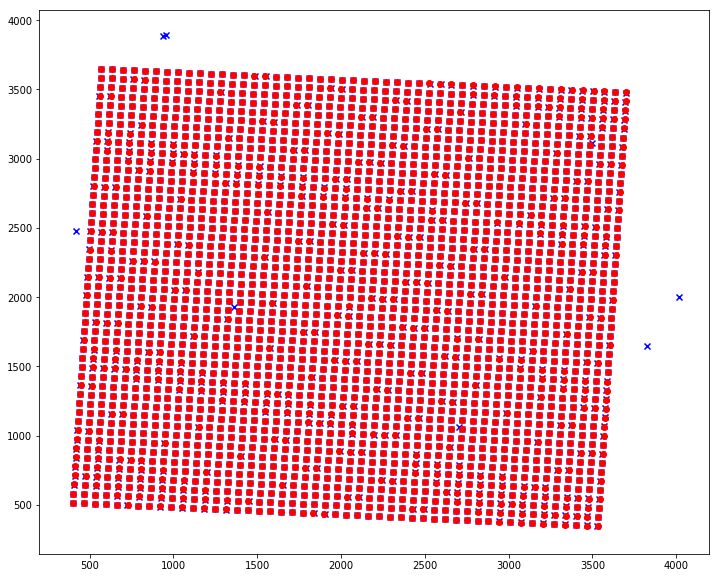

In [3]:
grid_task = SourceGridTask()
grid_task.config.brute_search = True

grid = grid_task.run(infile, (y0_guess, x0_guess))

gY = grid['Y']
gX = grid['X']

src = fits.getdata(infile)
srcY = src['base_SdssShape_Y']
srcX = src['base_SdssShape_X']

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(srcX, srcY, color='blue', marker='x')
ax.scatter(gX, gY, color='red')

In [4]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_-21.2_003/*.cat')
infile = infiles[0]
print(infile)

ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(-20.2, -127.0)

x0_guess = 2*509*4. - ccd_x
y0_guess = ccd_y

print(y0_guess, x0_guess)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_-21.2_003/R12_S10_source_catalog.cat
2000.5 4035.5


Parameters([('ystep', <Parameter 'ystep', value=65.31915128525037 (fixed), bounds=[-inf:inf]>), ('xstep', <Parameter 'xstep', value=65.25841955807577 (fixed), bounds=[-inf:inf]>), ('theta', <Parameter 'theta', value=-0.05350363792470869 (fixed), bounds=[-inf:inf]>), ('y0', <Parameter 'y0', value=1960.0, bounds=[1938.2269495715832:1981.7730504284168], brute_step=16.329787821312593>), ('x0', <Parameter 'x0', value=-83.68539511048107, bounds=[-121.75280651935859:-78.24719348064141], brute_step=16.314604889518943>)])
1960.8894076108245 -91.38372539733103


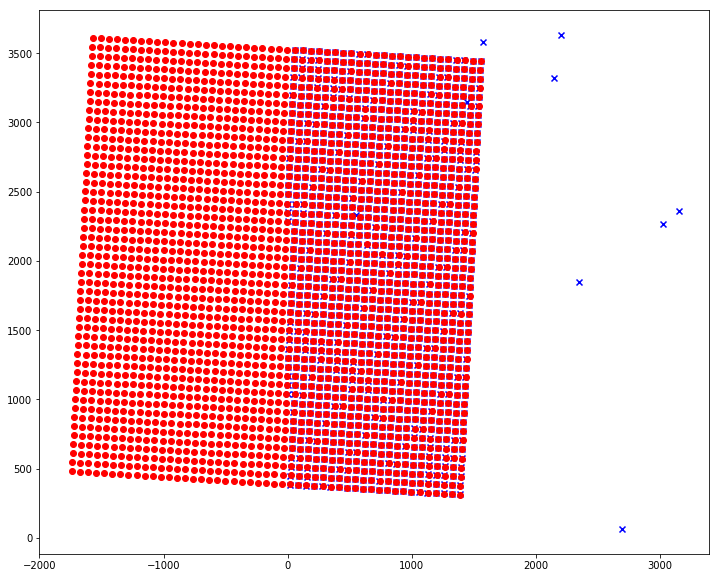

In [6]:
grid_task = SourceGridTask()
grid_task.config.brute_search = True

grid = grid_task.run(infile, (1960, -100), ccd_type='ITL')
print(grid.y0, grid.x0)
gY = grid['Y']
gX = grid['X']

src = fits.getdata(infile)
srcY = src['base_SdssShape_Y']
srcX = src['base_SdssShape_X']

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(srcX, srcY, color='blue', marker='x')
ax.scatter(gX, gY, color='red')

# Archive

In [ ]:
## Input
y0_guess = 2000.
x0_guess = 2000.
ncols = nrows = 49
distortions = None

## Module Code
src = fits.getdata(infile)

## Get source positions
srcY = src['base_SdssShape_X']
srcX = src['base_SdssShape_Y']

## Curate data here (remove bad shapes, fluxes, etc.)
srcW = np.sqrt(np.square(src['base_SdssShape_XX']) + np.square(src['base_SdssShape_YY']))
mask = (srcW > 4.)

srcY = src['base_SdssShape_X'][mask]
srcX = src['base_SdssShape_Y'][mask]

## Construct mask
nsources = srcY.shape[0]
indices, distances = coordinate_distances(srcY, srcX, srcY, srcX)
nn_indices = indices[:, 1:5]
nn_distances = distances[:, 1:5]
med_dist = np.median(nn_distances)

dist1_array = np.full(nsources, np.nan)
dist2_array = np.full(nsources, np.nan)
theta_array = np.full(nsources, np.nan)

for i in range(nsources):

    yc = srcY[i]
    xc = srcX[i]

    for j in range(4):

        nn_dist = nn_distances[i, j]
        if np.abs(nn_dist - med_dist) > 10.: continue
        y_nn = srcY[nn_indices[i, j]]
        x_nn = srcX[nn_indices[i, j]]

        if x_nn > xc:
            if y_nn > yc:
                dist1_array[i] = nn_dist
                theta_array[i] = np.arctan((y_nn-yc)/(x_nn-xc))
            else:
                dist2_array[i] = nn_dist

theta = np.nanmedian(theta_array)
if theta >= np.pi/4.:
    theta = theta - (np.pi/2.)
    xstep = np.nanmedian(dist2_array)
    ystep = np.nanmedian(dist1_array)
else:
    xstep = np.nanmedian(dist1_array)
    ystep = np.nanmedian(dist2_array)
    
print(theta)

## Perform Fit
params = Parameters()
params.add('ystep', value=ystep, vary=False)
params.add('xstep', value=xstep, vary=False)
params.add('theta', value=theta, vary=False)
params.add('y0', value=y0_guess, min=y0_guess-ystep, max=y0_guess+ystep, vary=True, brute_step=ystep/4.)
params.add('x0', value=x0_guess, min=x0_guess-xstep, max=x0_guess+xstep, vary=True, brute_step=xstep/4.)

print(params.valuesdict)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(method='brute', params=params)

params = result.params
params['theta'].set(vary=True)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(params=params)